# Dog vs Cat Classification using Pretrained ResNet-101

In this notebook, we will classify images of dogs and cats using a pretrained **ResNet-101** model from `torchvision.models`. We will use transfer learning to fine-tune the model on the Cats vs Dogs dataset.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models, datasets
import matplotlib.pyplot as plt
import numpy as np
import zipfile

In [15]:
import os
import warnings
from PIL import Image, UnidentifiedImageError
warnings.filterwarnings("ignore", category=UserWarning)

## 1. Device Configuration

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [22]:
# =====================================
# 2. Transform (only once for train/val)
# =====================================
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),   # ResNet expects 224x224
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [24]:
# =====================================
# 3. Safe Loader (skips corrupted images)
# =====================================
def safe_loader(path):
    try:
        with open(path, "rb") as f:
            img = Image.open(f).convert("RGB")
        return img
    except (UnidentifiedImageError, OSError):
        # Return a blank image if corrupted
        return Image.new("RGB", (224, 224))


In [25]:
# =====================================
# 4. Dataset & DataLoader
# =====================================
data_dir = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages"

# Load dataset with safe loader
full_dataset = datasets.ImageFolder(root=data_dir,
                                    transform=data_transform,
                                    loader=safe_loader)

# Split 80% train, 20% validation
train_size = int(0.8 * len(full_dataset))
val_size   = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}")


Train size: 20000, Validation size: 5000


## 3. Load Pretrained ResNet-101

In [26]:
# =====================================
# 5. Model Setup (ResNet101)
# =====================================
model = models.resnet101(pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for binary classification
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

model = model.to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


## 5. Training the Model

In [27]:
# =====================================
# 6. Training Loop
# =====================================
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Loss: {running_loss/len(train_loader):.4f}, "
          f"Acc: {train_acc:.2f}%")


Epoch [1/5], Loss: 0.0884, Acc: 96.88%
Epoch [2/5], Loss: 0.0457, Acc: 98.25%
Epoch [3/5], Loss: 0.0441, Acc: 98.37%
Epoch [4/5], Loss: 0.0443, Acc: 98.40%
Epoch [5/5], Loss: 0.0335, Acc: 98.75%


## 6. Evaluating the Model

In [28]:
# =====================================
# 7. Validation Loop
# =====================================
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

val_acc = 100 * correct / total
print(f"Validation Accuracy: {val_acc:.2f}%")


Validation Accuracy: 98.86%


## 7. Visualize Predictions

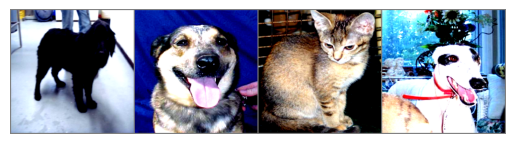

GroundTruth:  Dog Dog Cat Dog
Predicted:    Dog Dog Cat Dog


In [29]:
# =====================================
# 8. Quick Prediction & Visualization
# =====================================
import matplotlib.pyplot as plt
import torchvision
import numpy as np

# Class names
classes = ['Cat', 'Dog']

# Simple imshow (unnormalize roughly)
def imshow(img):
    img = img / 2 + 0.5  # unnormalize (approx)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

# Get a batch of validation images
dataiter = iter(val_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Run through model
outputs = model(images[:4])   # <-- using our ResNet101 model
_, predicted = torch.max(outputs, 1)

# Show images
imshow(torchvision.utils.make_grid(images[:4].cpu()))

# Print Ground Truth vs Predicted
print('GroundTruth: ', ' '.join(classes[labels[j]] for j in range(4)))
print('Predicted:   ', ' '.join(classes[predicted[j]] for j in range(4)))
